## Finding overlapping user bases
An example use case is this: you have a list of customers who have bought the various products that you sell. You want to know where the overlaps are, for example:
- How many customers who bought the Blue Widget also bought the Green Widget?
- Or what percentage of customers who bought the Blue Widget also bought the Green Widget?
- ... Or vice versa?

You have n numbers of products and a gazillion customers that bought them. Really this is just a bit of a data manipulation problem, followed by a nice Seaborn heatmap visualization. Let's go...!

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Import our data which consists of a list of products and which customers bought them
df = pd.read_excel('customer_product_list.xlsx')
df.head()

,Product,Customer
0,Blue widget,Customer 1
1,Blue widget,Customer 11
2,Blue widget,Customer 12
3,Blue widget,Customer 13
4,Blue widget,Customer 2


In [3]:
# How many records do we have?
print(f'''Number of records: {len(df)}''')

Number of records: 56


In [4]:
# How many products do we have?
print(f'''Number of products: {df['Product'].nunique()}''')

Number of products: 4


In [5]:
# How many customers do we have?
print(f'''Number of customers: {df['Customer'].nunique()}''')

Number of customers: 30


### Data manipulation
Given that we have 4 products, we want to end up with a 4 x 4 matrix that will show us the extent of overlap between the products and the customers that purchased them.

#### Step 1
Change our data from this format:
<img src = 'https://shotlefttodatascience.files.wordpress.com/2020/05/screenshot-2020-05-19-at-11.57.14.png' width = 250>
... to this format (each row represents a unique customer and the products they have bought):   
<img src = 'https://shotlefttodatascience.files.wordpress.com/2020/05/screenshot-2020-05-19-at-11.58.41.png' width = 450>

In [6]:
# Get a unique list of products and customers
list_product = list(set(df['Product']))
list_customer = list(set(df['Customer']))

# Let's sort the product list, because later when we visualize our data it will be
# handy if the products are sorted alphabetically (especially when you have more than 4!)
list_product.sort()

# Put these lists into series format which we can use to match back to the main df.
# Essentially here we are getting a unique index for each product and customer
product_match = pd.Series(list(range(len(list_product))), list_product)
customer_match = pd.Series(list(range(len(list_customer))), list_customer)
df['ProductNum'] = df['Product'].map(product_match)
df['CustomerNum'] = df['Customer'].map(customer_match)

# The end result is as follows
df.head(10)

,Product,Customer,ProductNum,CustomerNum
0,Blue widget,Customer 1,0,29
1,Blue widget,Customer 11,0,12
2,Blue widget,Customer 12,0,20
3,Blue widget,Customer 13,0,28
4,Blue widget,Customer 2,0,7
5,Blue widget,Customer 3,0,24
6,Blue widget,Customer 4,0,22
7,Blue widget,Customer 5,0,15
8,Blue widget,Customer 6,0,23
9,Blue widget,Customer 7,0,5


In [7]:
# Processing things in dataframes can take a while once you have 1 million + records,
# so we're going to put our newly created indices into lists
product_indices = list(df['ProductNum'])
customer_indices = list(df['CustomerNum'])

In [8]:
# Here we are creating an empty matrix where the rows represent our unique customers
# and the columns represent our unique products
purchases_matrix = np.zeros((len(list_customer), len(list_product)))
purchases_matrix.shape

(30, 4)

In [9]:
# And now we loop over our data to populate this matrix with a 1 wherever a customer bought the corresponding product
for i in range(len(product_indices)):
    purchases_matrix[customer_indices[i]][product_indices[i]] = 1

In [10]:
# Let's put that result back into a df for easy viewing, and further processing
purchases_summary = pd.DataFrame(data=purchases_matrix, index=list_customer, columns=list_product)
purchases_summary.head(10)

,Blue widget,Green widget,Orange widget,Yellow widget
Customer 21,0.0,1.0,0.0,0.0
Customer 19,0.0,1.0,0.0,0.0
Customer 31,0.0,0.0,1.0,1.0
Customer 26,0.0,1.0,0.0,1.0
Customer 30,0.0,1.0,0.0,1.0
Customer 7,1.0,0.0,0.0,0.0
Customer 16,0.0,1.0,1.0,0.0
Customer 2,1.0,0.0,1.0,0.0
Customer 22,0.0,1.0,0.0,0.0
Customer 18,0.0,1.0,0.0,0.0


#### Step 2
Obtain a 4 x 4 matrix, representing the overlaps:

In [11]:
# Now we're on the way to our finished product, a 4 x 4 matrix of our products and where their overlaps occur
# First we're creating an empty matrix to hold our results
product_matrix = np.zeros((len(list_product), len(list_product)))
product_matrix.shape

(4, 4)

In [12]:
# And now we loop over our (reduced) dataframe and sum up the overlaps - if processing was still
# slow here we could shunt this part in numpy as well, but for my scenario it turned out to be 
# quick enough to stick with this convenient method
for i in range(len(list_product)):
    for t in range(len(list_product)):
        product_matrix[i][t] = len(purchases_summary[(purchases_summary[list_product[i]] == 1) & 
                                                     (purchases_summary[list_product[t]] == 1)])

In [13]:
# Let's put that result back into a df - we now have the numbers of overlaps across the products!
product_summary = pd.DataFrame(data=product_matrix, index=list_product, columns=list_product)
product_summary.head()

,Blue widget,Green widget,Orange widget,Yellow widget
Blue widget,10.0,3.0,6.0,2.0
Green widget,3.0,20.0,5.0,12.0
Orange widget,6.0,5.0,12.0,6.0
Yellow widget,2.0,12.0,6.0,14.0


In [14]:
# Let's do the same again, but this time we'll get percentages
product_matrix_percentages = np.zeros((len(list_product), len(list_product)))
product_matrix_percentages.shape

for i in range(len(list_product)):
    for t in range(len(list_product)):
        product_matrix_percentages[i][t] = int(round(len(purchases_summary[(purchases_summary[list_product[i]] == 1) & 
                                                                 (purchases_summary[list_product[t]] == 1)]) / 
                                           len(purchases_summary[(purchases_summary[list_product[i]] == 1)]) * 100, 0))

product_percentages = pd.DataFrame(data=product_matrix_percentages, index=list_product, columns=list_product)
product_percentages.head()

,Blue widget,Green widget,Orange widget,Yellow widget
Blue widget,100.0,30.0,60.0,20.0
Green widget,15.0,100.0,25.0,60.0
Orange widget,50.0,42.0,100.0,50.0
Yellow widget,14.0,86.0,43.0,100.0


### Visualization
This is the easy bit, once we have our data in the format required!
There are some handy parameters with sns.heatmap() as follows:
- `annot = True`: labels the blocks with the data provided
- `annot = some_other_like_sized_array`: labels the blocks with the data from specified array
- `fmt = 'g'`: used to make sure our numbers are displayed as integers
- `vmax = 75`: anything above 75 will be coloured in our 100% colour, you have to experiment with this number to see what works best visually
- `ax.xaxis.tick_top()`: puts the x-axis labels at the top which will be more intuitive for most business readers
- `ax.set_xticklabels(labels = list_product, rotation=90)`: may come in useful for longer product names, rotates them sideways so they don't overlap each other

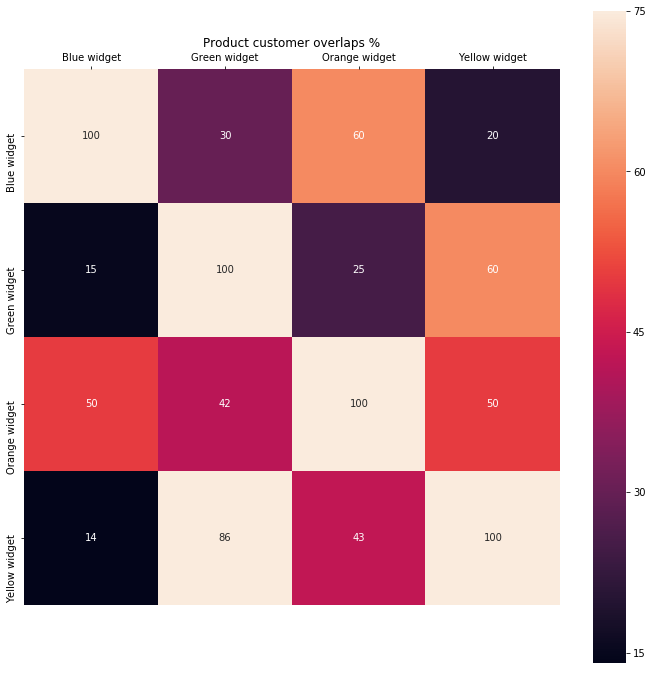

In [15]:
# Here we have the visualization by %
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(product_percentages, vmax = 75, square = True, annot=True, fmt='g')
ax.xaxis.tick_top()
plt.title('Product customer overlaps %')
plt.show()

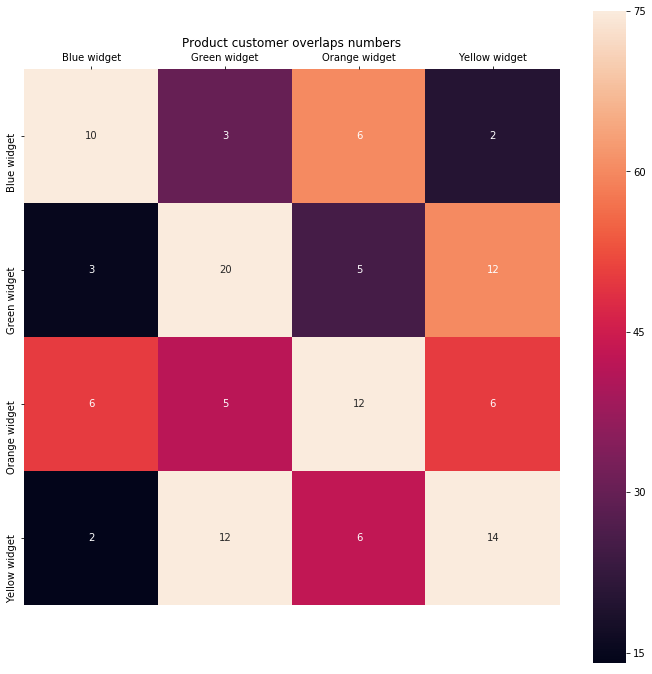

In [16]:
# And here we have the visualization by % again BUT using the annot parameter I'm overlaying
# the actual counts from product_summary: the end-result is the colours align to our original 
# percentage visualization above, but we can see the detail
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(product_percentages, vmax = 75, square = True, annot=product_summary, fmt='g')
ax.xaxis.tick_top()
plt.title('Product customer overlaps numbers')
plt.show()